In [1]:
import csv
import pandas as pd

In [39]:
import numpy as np
from sklearn.decomposition import PCA

In [149]:
quarterbacks_df = pd.read_csv('./ProData/csvs/qb_stats.csv', header=0)

In [250]:
player_id_and_age_df = quarterbacks_df[['age', 'player_id']].set_index('player_id')

In [251]:
drop_columns = [col for col in quarterbacks_df.columns if col.startswith(('catch', 'rec', 'targets'))]

In [252]:
drop_columns.extend(['Unnamed: 0', 'team', 'rush_receive_td', 'av'])

In [253]:
qbs_df = quarterbacks_df.drop(drop_columns, axis=1)

In [254]:
norm_cols = [col for col in qbs_df.columns if col not in ['player_id', 'age']] 

In [255]:
normalized_qb_df = qbs_df

In [256]:
normalized_qb_df[norm_cols] = qbs_df[norm_cols].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [257]:
normalized_qb_df.head()

,age,g,gs,pass_cmp,pass_att,pass_cmp_perc,pass_yds,pass_td,pass_td_perc,pass_int,...,yds_from_scrimmage,fumbles,snaps_played,total_snaps,snap_played_percentage,wins,losses,ties,win_percentage,player_id
0,43,1.0000,1.0000,0.851380,0.839065,0.657,0.846168,0.80,0.132,0.400000,...,0.017199,0.190476,0.842798,0.673750,0.95,0.6875,0.357143,0.0,0.687500,BradTo00
1,38,0.2500,0.2500,0.193206,0.202201,0.619,0.190876,0.12,0.082,0.166667,...,0.018018,0.142857,0.204115,0.160000,0.97,0.0625,0.214286,0.0,0.250000,MannEl00
2,38,1.0000,1.0000,0.819533,0.737276,0.720,0.791606,0.46,0.086,0.266667,...,0.022113,0.238095,0.849383,0.645000,1.00,0.6875,0.357143,0.0,0.687500,BreeDr00
3,38,0.3750,0.0625,0.106157,0.092160,0.746,0.106569,0.06,0.090,0.033333,...,0.009828,0.047619,0.081481,0.257500,0.24,0.0000,0.000000,0.0,0.000000,SchaMa00
4,38,0.4375,0.4375,0.348195,0.367263,0.614,0.361679,0.18,0.068,0.233333,...,0.022113,0.095238,0.377778,0.301875,0.95,0.1875,0.285714,0.0,0.428571,PalmCa00


In [258]:
normalized_qb_df.set_index(['player_id', 'age'], inplace=True)

In [347]:
normalized_qb_df.columns

Index(['g', 'gs', 'pass_cmp', 'pass_att', 'pass_cmp_perc', 'pass_yds',
       'pass_td', 'pass_td_perc', 'pass_int', 'pass_int_perc',
       'pass_first_down', 'pass_long', 'pass_yds_per_att',
       'pass_adj_yds_per_att', 'pass_yds_per_cmp', 'pass_yds_per_g',
       'pass_rating', 'qbr', 'pass_sacked', 'pass_sacked_yds',
       'pass_sacked_perc', 'pass_net_yds_per_att', 'pass_adj_net_yds_per_att',
       'comebacks', 'gwd', 'rush_att', 'rush_yds', 'rush_td',
       'rush_first_down', 'rush_long', 'rush_yds_per_att', 'rush_yds_per_g',
       'rush_att_per_g', 'touches', 'yds_per_touch', 'yds_from_scrimmage',
       'fumbles', 'snaps_played', 'total_snaps', 'snap_played_percentage',
       'wins', 'losses', 'ties', 'win_percentage'],
      dtype='object')

## Fill Null
For columns that were always available (not advanced metrics) fill with 0

In [260]:
colums_to_fill_with_zero = [
    'comebacks', 'fumbles', 'gwd', 'losses', 'pass_adj_net_yds_per_att',
    'pass_adj_yds_per_att', 'pass_att', 'pass_cmp', 'pass_cmp_perc', 'pass_first_down',
    'pass_int', 'pass_int_perc', 'pass_long', 'pass_net_yds_per_att',
    'pass_rating', 'pass_sacked', 'pass_sacked_perc', 'pass_sacked_yds',
    'pass_td', 'pass_td_perc', 'pass_yds', 'pass_yds_per_att',
    'pass_yds_per_cmp', 'pass_yds_per_g', 'ties', 'win_percentage', 'wins',
    'rush_att', 'rush_att_per_g','rush_first_down','rush_long','rush_td',
    'rush_yds', 'rush_yds_per_att', 'rush_yds_per_g', 'touches',
    'yds_from_scrimmage'
]
fill_null_object = {key:0 for key in colums_to_fill_with_zero}

In [312]:
df = normalized_qb_df.fillna(value=fill_null_object, axis=0)

In [313]:
normal_qb_dropna = df.dropna(axis=1)

In [263]:
sorted(set(df.columns) - set(normal_qb_dropna.columns))

['qbr',
 'snap_played_percentage',
 'snaps_played',
 'total_snaps',
 'yds_per_touch']

In [195]:
len(df[df['qbr'] == 0])

165

In [196]:
len(df)

1099

In [236]:
len(df[df.isnull()])

1099

## Fillna for each player with the player's average
QBR was only available starting in 2006 and snap data in 2012. For players that span across those time ranges, use their average to fill data from time before it was available.

In [264]:
fillna_cols = ['qbr', 'snap_played_percentage', 'snaps_played', 'total_snaps']

In [274]:
def fill_with_player_averages(group):
    group[fillna_cols] = group[fillna_cols].replace(0, group[fillna_cols].mean())
    group[fillna_cols] = group[fillna_cols].fillna(group[fillna_cols].mean())
    return group

In [314]:
new = df.groupby('player_id', as_index=False).apply(fill_with_player_averages)

In [315]:
new.query('player_id=="BradTo00"')['snap_played_percentage']

player_id  age
BradTo00   43     0.950
           38     0.990
           34     0.973
           23     0.973
           35     0.980
           39     0.960
           42     0.990
           32     0.973
           24     0.973
           28     0.973
           29     0.973
           44     0.960
           25     0.973
           33     0.973
           26     0.973
           30     0.973
           31     0.973
           27     0.973
           41     0.980
           36     1.000
           37     0.940
           40     0.980
Name: snap_played_percentage, dtype: float64

## Fill zeros and nulls with all average

In [316]:
new[fillna_cols] = new[fillna_cols].fillna(new[fillna_cols].mean())

In [317]:
new[fillna_cols] = new[fillna_cols].replace(0, new[fillna_cols].mean())

In [318]:
normal_qb_dropna = new.dropna(axis=1)

In [323]:
normal_qb_dropna.columns

Index(['g', 'gs', 'pass_cmp', 'pass_att', 'pass_cmp_perc', 'pass_yds',
       'pass_td', 'pass_td_perc', 'pass_int', 'pass_int_perc',
       'pass_first_down', 'pass_long', 'pass_yds_per_att',
       'pass_adj_yds_per_att', 'pass_yds_per_cmp', 'pass_yds_per_g',
       'pass_rating', 'qbr', 'pass_sacked', 'pass_sacked_yds',
       'pass_sacked_perc', 'pass_net_yds_per_att', 'pass_adj_net_yds_per_att',
       'comebacks', 'gwd', 'rush_att', 'rush_yds', 'rush_td',
       'rush_first_down', 'rush_long', 'rush_yds_per_att', 'rush_yds_per_g',
       'rush_att_per_g', 'touches', 'yds_from_scrimmage', 'fumbles',
       'snaps_played', 'total_snaps', 'snap_played_percentage', 'wins',
       'losses', 'ties', 'win_percentage'],
      dtype='object')

In [332]:
pca = PCA(n_components=1)

In [333]:
pca_analysis = pd.DataFrame(
    pca.fit_transform(normal_qb_dropna), 
    columns=['PCA%i' % i for i in range(1)], 
    index=normal_qb_dropna.index)

# Plot Age vs Feature

In [334]:
import matplotlib.pyplot as plt

In [335]:
pca_analysis.reset_index('age', inplace=True)

In [348]:
top_50 = pca_analysis.sort_values('PCA0', axis=0, ascending=False).head(50)

In [362]:
top50 = top_50.reset_index('player_id')

In [372]:
sorted_stats = pca_analysis.sort_values('PCA0', axis=0, ascending=False)
sorted_stats.reset_index('player_id', inplace=True)
sorted_stats[sorted_stats['player_id'] == 'MannPe00']

,player_id,age,PCA0


In [350]:
#top_50.groupby('player_id').size()

In [351]:
#pca_analysis.sort_values('PCA0', axis=0).head(20)

In [353]:
players_per_age = pca_analysis.groupby('age').size().to_frame().reset_index('age')
players_per_age = players_per_age[players_per_age['age'] != 0]

average_pca_per_age = pca_analysis.groupby('age').mean().reset_index('age')
average_pca_per_age = average_pca_per_age[average_pca_per_age['age'] != 0]

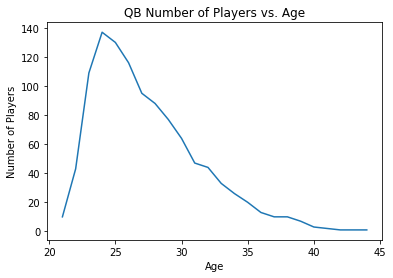

In [373]:
plt.plot(players_per_age['age'], players_per_age[0])
plt.title('QB Number of Players vs. Age')
plt.xlabel('Age')
plt.ylabel('Number of Players')
plt.savefig('qb_player_v_age.png')
plt.show()

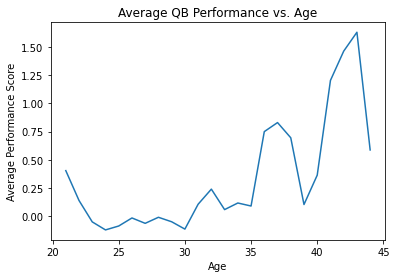

In [374]:
plt.plot(average_pca_per_age['age'], average_pca_per_age['PCA0'])
plt.title('Average QB Performance vs. Age')
plt.xlabel('Age')
plt.ylabel('Average Performance Score')
plt.savefig('qb_perf_v_age.png')
plt.show()

In [320]:
df_for_plotting = normal_qb_dropna.reset_index('age')

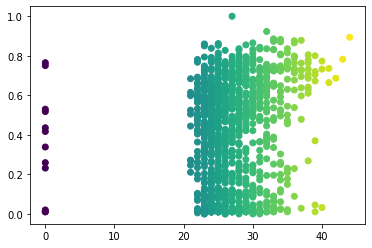

In [324]:
fig, ax = plt.subplots()
ax.scatter(df_for_plotting['age'], df_for_plotting['pass_yds_per_g'], c=df_for_plotting['age'])